# Stock Price Prediction Modeling

This notebook focuses on predicting target asset behavior using peer features as predictors.

## Training Configuration
- Training Period: 2020-01-01 to 2023-12-31
- Validation Splits: 5 (TimeSeriesSplit)
- Target: Close price prediction
- Features: Technical indicators from target and peer assets

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

logger = logging.getLogger(__name__)

# Now import the feature preparation module
from src.features.feature_model_prep import prepare_features, create_period_masks, validate_training_period


# Load configuration
with open('../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

## Data Loading and Preprocessing

This section handles data loading and initial preprocessing steps for model training.

### Configuration
- Training Period: Loading from config file
- Data Source: Preprocessed features from all_features.pkl
- Timezone: America/New_York (ET)
- Feature Types: Technical indicators and market data

### Preprocessing Steps
1. Load and validate configuration
2. Filter data to training period
3. Remove data leakage features
4. Split features into target and peer sets
5. Create feature combinations
   - Peers only
   - Peers + target technical indicators

### Data Validation
- Minimum required data: 252 trading days
- Timezone consistency checks
- Feature completeness verification
- Leakage prevention measures

### Outputs
- Clean feature sets (X)
- Target variable (y)
- Data split information
- Feature filtering logs

In [2]:
# Load and prepare features
logger.info("Loading feature data...")
all_features = pd.read_pickle('../data/processed/all_features.pkl')

# Remove first 60 days of data
all_features = all_features.iloc[60:]

# Validate periods and create masks
periods = config['periods']
target_symbol = config['target_symbol']
peer_symbols = config['peer_symbols']

prediction_horizon = config['prediction_horizon']

# Create period masks
masks = create_period_masks(all_features, periods)

# Prepare features with config-based filtering
X_full, y_full, feature_names = prepare_features(
    all_features, 
    target_symbol, 
    peer_symbols,
    config
)

# Split data using masks
X_train = X_full[masks['training']]
y_train = y_full[masks['training']]
X_test = X_full[masks['test']]
y_test = y_full[masks['test']]
X_strategy = X_full[masks['strategy']]
y_strategy = y_full[masks['strategy']]

# Log data info
logger.info(f"\nData Split Summary:")
logger.info(f"Training samples: {len(X_train)}")
logger.info(f"Test samples: {len(X_test)}")
logger.info(f"Strategy samples: {len(X_strategy)}")

2025-06-05 14:29:29,715 - __main__ - INFO - Loading feature data...
2025-06-05 14:29:29,918 - src.features.feature_model_prep - INFO - Available columns: ['MSFT_Dividends', 'MSFT_Stock Splits', 'MSFT_RSI', 'MSFT_MACD', 'MSFT_Signal', 'MSFT_Histogram', 'MSFT_BB_Upper', 'MSFT_BB_Lower', 'MSFT_BB_Middle', 'MSFT_CCI', 'MSFT_STOCH_K', 'MSFT_STOCH_D', 'MSFT_ATR', 'MSFT_OBV', 'MSFT_OBV_SMA', 'MSFT_ICHIMOKU_CONV', 'MSFT_ICHIMOKU_BASE', 'MSFT_Close_sma_5', 'MSFT_Volume_sma_5', 'MSFT_High_sma_5', 'MSFT_Low_sma_5', 'MSFT_Close_sma_10', 'MSFT_Volume_sma_10', 'MSFT_High_sma_10', 'MSFT_Low_sma_10', 'MSFT_Close_sma_20', 'MSFT_Volume_sma_20', 'MSFT_High_sma_20', 'MSFT_Low_sma_20', 'MSFT_Close_sma_50', 'MSFT_Volume_sma_50', 'MSFT_High_sma_50', 'MSFT_Low_sma_50', 'MSFT_Close_lag_1', 'MSFT_Close_lag_2', 'MSFT_Close_lag_3', 'MSFT_Close_lag_5', 'MSFT_Close_lag_10', 'MSFT_Close_lag_20', 'MSFT_High_lag_1', 'MSFT_High_lag_2', 'MSFT_High_lag_3', 'MSFT_High_lag_5', 'MSFT_High_lag_10', 'MSFT_High_lag_20', 'MSFT_

In [6]:
all_features.to_csv('../data/processed/all_features.csv', index=False)

## Model Training and Hyperparameter Optimization

This section implements XGBoost model training with hyperparameter tuning using RandomizedSearchCV.

### Hyperparameter Search Space
- max_depth: [3-8] Tree depth
- learning_rate: [0.01-0.2] Step size shrinkage
- n_estimators: [50-200] Number of trees
- min_child_weight: [1-5] Minimum sum of instance weight
- subsample: [0.6-0.9] Fraction of samples used
- colsample_bytree: [0.6-0.9] Fraction of features used

### Training Process
1. Scale features using StandardScaler
2. Convert to DMatrix format for XGBoost
3. Perform RandomizedSearchCV with time series splits
4. Train final model with best parameters
5. Early stopping to prevent overfitting

### Outputs
- Model performance metrics (MSE, R²)
- Feature importance rankings
- Actual vs Predicted visualizations
- Serialized model and predictions

In [3]:
# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Fit scalers on training data only
X_train_scaled = pd.DataFrame(
    feature_scaler.fit_transform(X_train),
    index=X_train.index,
    columns=X_train.columns
)
y_train_scaled = pd.Series(
    target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel(),
    index=y_train.index
)

# Transform test and strategy data using training period scalers
X_test_scaled = pd.DataFrame(
    feature_scaler.transform(X_test),
    index=X_test.index,
    columns=X_test.columns
)
X_strategy_scaled = pd.DataFrame(
    feature_scaler.transform(X_strategy),
    index=X_strategy.index,
    columns=X_strategy.columns
)
y_test_scaled = pd.Series(
    target_scaler.transform(y_test.values.reshape(-1, 1)).ravel(),
    index=y_test.index
)
y_strategy_scaled = pd.Series(
    target_scaler.transform(y_strategy.values.reshape(-1, 1)).ravel(),
    index=y_strategy.index
)

# Define parameter space for random search
param_space = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.03, 0.05],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

# Initialize base model for random search
base_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    early_stopping_rounds=10,
    eval_metric='rmse'
)

# Create TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize and run RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_space,
    n_iter=25,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit random search with SCALED target values
logger.info("Starting RandomizedSearchCV...")
random_search.fit(
    X_train_scaled, 
    y_train_scaled,  # Use scaled target values
    eval_set=[(X_train_scaled, y_train_scaled)],  # Use scaled target values
    verbose=False
)

# Train final model with best parameters using SCALED target values
model = xgb.XGBRegressor(**random_search.best_params_)
model.fit(
    X_train_scaled, 
    y_train_scaled,  # Use scaled target values
    eval_set=[(X_train_scaled, y_train_scaled)],  # Use scaled target values
    verbose=50
)

# Generate predictions and inverse transform them (this part is correct)
predictions = {
    'training': pd.Series(
        target_scaler.inverse_transform(
            model.predict(X_train_scaled).reshape(-1, 1)
        ).ravel(),
        index=X_train.index
    ),
    'test': pd.Series(
        target_scaler.inverse_transform(
            model.predict(X_test_scaled).reshape(-1, 1)
        ).ravel(),
        index=X_test.index
    ),
    'strategy': pd.Series(
        target_scaler.inverse_transform(
            model.predict(X_strategy_scaled).reshape(-1, 1)
        ).ravel(),
        index=X_strategy.index
    )
}


c:\Users\Kenrm\repositories\stock-prediction-ml\.venv\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\Kenrm\repositories\stock-prediction-ml\.venv\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\Kenrm\repositories\stock-prediction-ml\.venv\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
2025-06-05 14:29:35,881 - __main__ - INFO - Starting RandomizedSearchCV...


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[0]	validation_0-rmse:0.97276
[50]	validation_0-rmse:0.29902
[100]	validation_0-rmse:0.15413
[150]	validation_0-rmse:0.12060
[200]	validation_0-rmse:0.10689
[250]	validation_0-rmse:0.09802
[299]	validation_0-rmse:0.09148


In [4]:
# Create period masks for metrics calculation - corrected version
predictions_series = pd.concat([
    predictions['training'],
    predictions['test'],
    predictions['strategy']
]).sort_index()

# Keep as Series, don't convert to DataFrame
# predictions_series = pd.DataFrame(predictions_series)  # Remove this line

actual_prices = pd.concat([y_train, y_test, y_strategy]).sort_index()

# Verify both are in the same scale
print(f"Actual prices range: {actual_prices.min():.2f} to {actual_prices.max():.2f}")
print(f"Predictions range: {predictions_series.min():.2f} to {predictions_series.max():.2f}")

Actual prices range: 156.20 to 464.00
Predictions range: 162.43 to 370.60


## Model Evaluation and Visualization

This section analyzes the model's performance and feature importance through metrics and visualizations.

### Performance Metrics
- Mean Squared Error (MSE): Measures prediction accuracy
- R-squared (R²): Indicates variance explained by model
- Feature Importance: Top predictive indicators

### Visualizations
1. **Feature Importance Plot**
   - Top 20 most influential features
   - Relative importance weights
   - Technical vs peer indicators

2. **Prediction Analysis**
   - Actual vs Predicted prices
   - Visual fit assessment
   - Trend capture evaluation

### Key Insights
- Model's predictive accuracy
- Most influential technical indicators
- Cross-asset relationships
- Potential areas for improvement

The visualizations help identify:
- Feature selection effectiveness
- Model's strength in different market conditions
- Potential overfitting or underfitting
- Areas needing feature engineering

C:\Users\Kenrm\AppData\Local\Temp\ipykernel_30328\1458880297.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


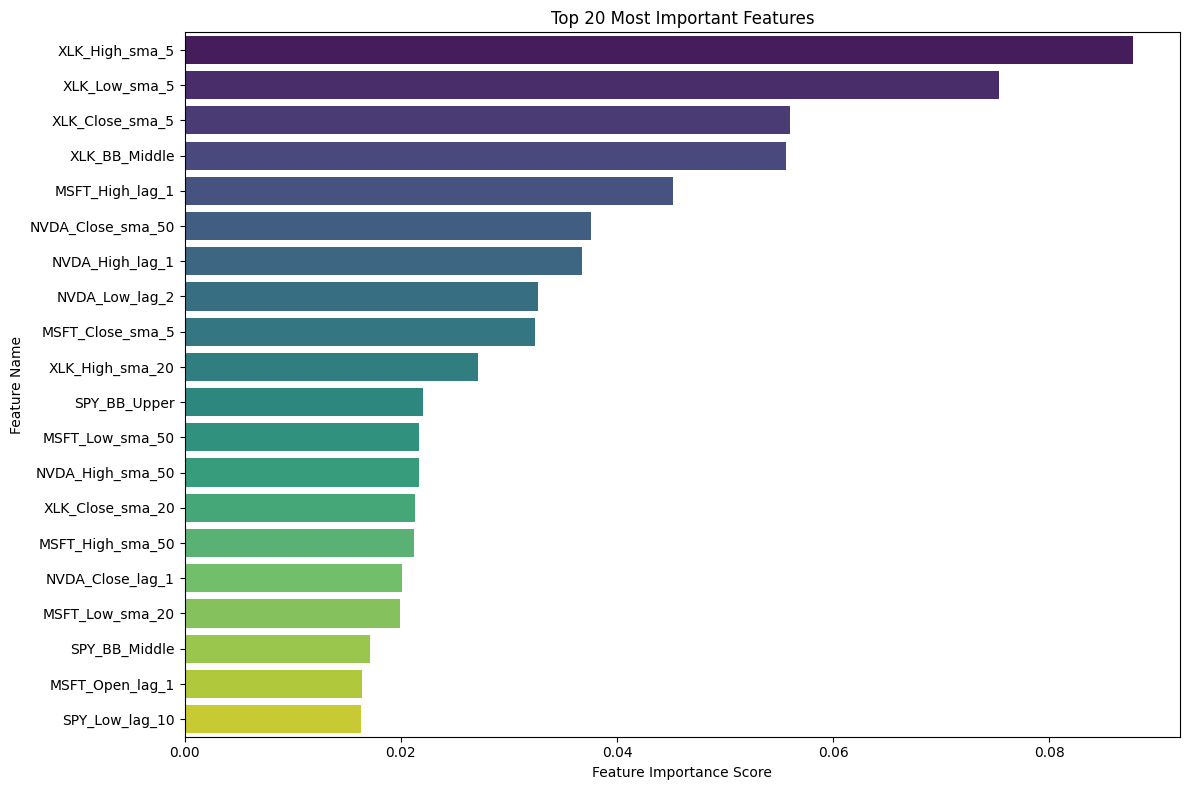


Top 10 Most Important Features:
          feature  importance
   XLK_High_sma_5    0.087695
    XLK_Low_sma_5    0.075359
  XLK_Close_sma_5    0.055996
    XLK_BB_Middle    0.055647
  MSFT_High_lag_1    0.045161
NVDA_Close_sma_50    0.037556
  NVDA_High_lag_1    0.036771
   NVDA_Low_lag_2    0.032669
 MSFT_Close_sma_5    0.032370
  XLK_High_sma_20    0.027163


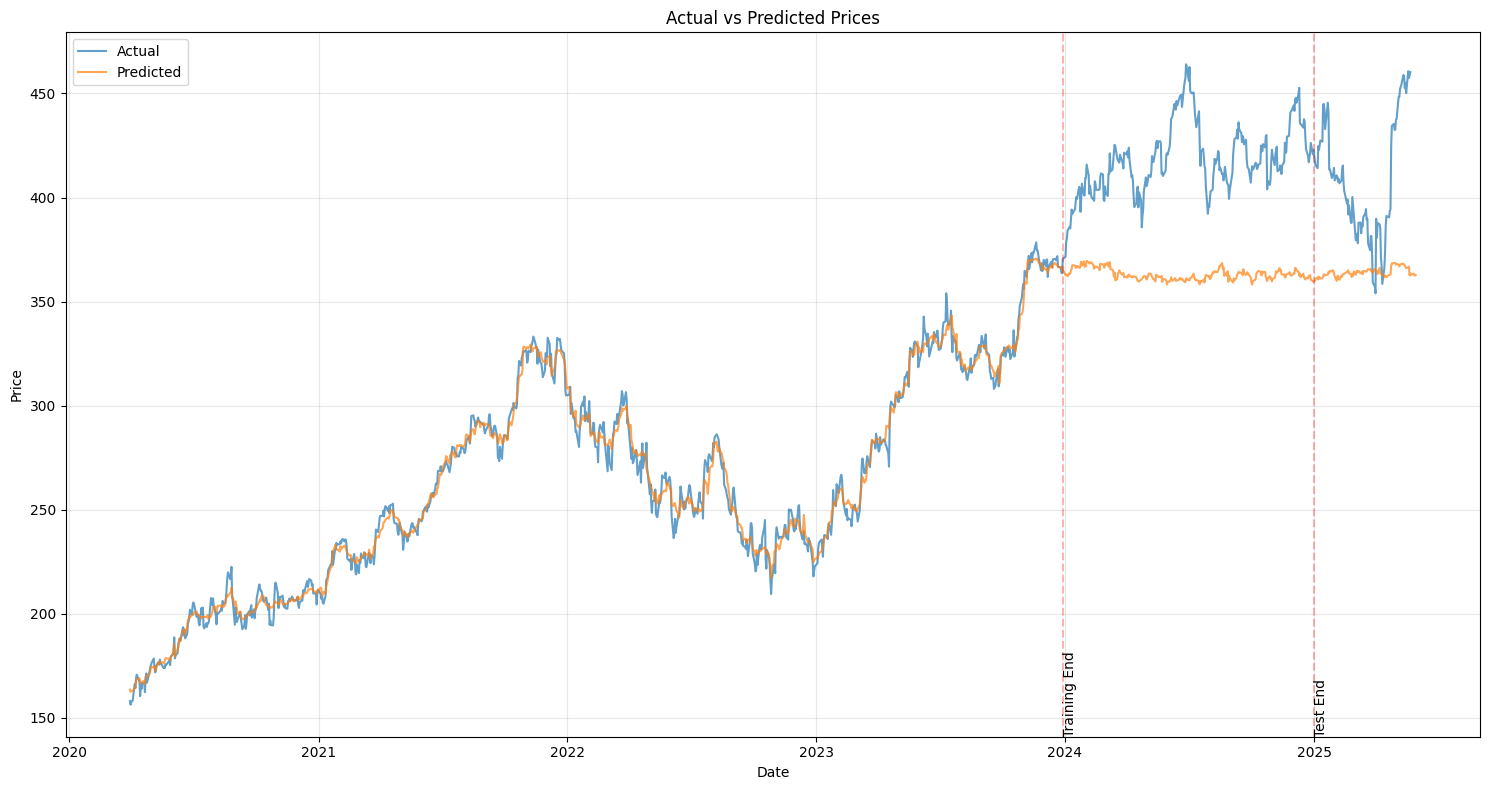

ValueError: Input contains NaN.

In [5]:
# Feature importance with proper labels
importance_dict = {
    name: score for name, score in zip(
        X_train.columns,
        model.feature_importances_
    )
}
importance_df = pd.DataFrame(
    list(importance_dict.items()),
    columns=['feature', 'importance']
)
importance_df = importance_df.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
n_features = min(20, len(importance_df))
sns.barplot(
    data=importance_df.head(n_features),
    x='importance',
    y='feature',
    palette='viridis'
)
plt.title(f'Top {n_features} Most Important Features')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

# Print detailed feature importance
print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Create period masks for metrics calculation
predictions_series = pd.concat([
    predictions['training'],
    predictions['test'],
    predictions['strategy']
]).sort_index()

predictions_series = pd.DataFrame(predictions_series)

actual_prices = pd.concat([y_train, y_test, y_strategy]).sort_index()

training_mask = masks['training']
test_mask = masks['test']
strategy_mask = masks['strategy']


# Create period masks for metrics calculation
predictions_series = pd.concat([
    predictions['training'],
    predictions['test'],
    predictions['strategy']
]).sort_index()

actual_prices = pd.concat([y_train, y_test, y_strategy]).sort_index()

# Plot actual vs predicted prices
plt.figure(figsize=(15, 8))
plt.plot(actual_prices.index, actual_prices.values, label='Actual', alpha=0.7)
plt.plot(predictions_series.index, predictions_series.values, label='Predicted', alpha=0.7)

# Add vertical lines to separate periods
period_dates = {
    'Training End': y_train.index[-1],
    'Test End': y_test.index[-1]
}

for label, date in period_dates.items():
    plt.axvline(x=date, color='r', linestyle='--', alpha=0.3)
    plt.text(date, plt.ylim()[0], label, rotation=90, verticalalignment='bottom')

plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Calculate metrics for each period
metrics = {
    'training': {
        'mse': mean_squared_error(
            y_train, 
            predictions['training']
        ),
        'r2': r2_score(
            y_train, 
            predictions['training']
        )
    },
    'test': {
        'mse': mean_squared_error(
            y_test,
            predictions['test']
        ),
        'r2': r2_score(
            y_test,
            predictions['test']
        )
    },
    'strategy': {
        'mse': mean_squared_error(
            y_strategy, 
            predictions['strategy']
        ),
        'r2': r2_score(
            y_strategy, 
            predictions['strategy']
        )
    }
}

# Print metrics for all periods
for period, period_metrics in metrics.items():
    print(f"\n{period.capitalize()} Period Metrics:")
    print(f"MSE: {period_metrics['mse']:.4f}")
    print(f"R²: {period_metrics['r2']:.4f}")

In [ ]:
# Verify the target variable fix
print("=== TARGET VARIABLE CORRECTION VERIFICATION ===")

print(f"\n1. Config prediction horizon: {config.get('prediction_horizon', 'Not found')}")

print("\n2. Check target variable alignment:")
# Compare original close vs target variable
original_close = all_features[f'{target_symbol}_Close']
print("Sample comparison (today's close vs target variable):")
sample_dates = y_train.index[:10]
for i, date in enumerate(sample_dates):
    if date in original_close.index:
        orig_today = original_close.loc[date]
        target_val = y_train.iloc[i]
        print(f"{date}: Today_Close={orig_today:.2f}, Target={target_val:.2f}")

print("\n3. New correlation check (should be much lower now):")
correlation = np.corrcoef(y_train.values, X_train['MSFT_Close_lag_1'].values)[0,1]
print(f"Correlation between target and lag-1: {correlation:.6f}")
print("Expected: Should be much lower than 0.99 (around 0.7-0.9 for stock prices)")

print("\n4. Check if target is future price:")
# This should show that target is 5 days ahead
print("Verify target is 5 days ahead:")
for i in range(5):
    date_today = y_train.index[i]
    target_val = y_train.iloc[i]
    
    # Try to find the date 5 days ahead in original data
    try:
        future_idx = original_close.index.get_loc(date_today) + 5
        if future_idx < len(original_close):
            future_date = original_close.index[future_idx]
            future_close = original_close.iloc[future_idx]
            print(f"Today: {date_today}, Target: {target_val:.2f}")
            print(f"  5 days later: {future_date}, Actual Close: {future_close:.2f}")
            print(f"  Match: {abs(target_val - future_close) < 0.01}")
    except:
        print(f"Could not verify for {date_today}")

print(f"\n5. Expected model performance improvement:")
print("With proper 5-day ahead prediction:")
print("- Training R² should be 0.3-0.8 (realistic for stock prediction)")
print("- Test R² should be positive and reasonable") 
print("- Feature importance should show more diverse technical indicators")

In [ ]:
# Export X_train_scaled to CSV file
output_path = '../data/processed/X_train_scaled.csv'
import os
# Create directory if it doesn't exist
os.makedirs('../data/processed', exist_ok=True)

# Export to CSV
X_train_scaled.to_csv(output_path)

print(f"X_train_scaled exported to: {output_path}")
print(f"Shape: {X_train_scaled.shape}")
print(f"Columns: {len(X_train_scaled.columns)}")
print(f"Date range: {X_train_scaled.index.min()} to {X_train_scaled.index.max()}")

In [11]:
# =============================================================================
# COMPREHENSIVE DATA CLEANING FOR LINEAR REGRESSION
# =============================================================================

print("=== COMPREHENSIVE DATA CLEANING FOR LINEAR REGRESSION ===")

# Check for missing values in features
print(f"\nOriginal feature data shape: {X_train_scaled.shape}")
print(f"Feature missing values per column:")
missing_counts = X_train_scaled.isnull().sum()
print(f"Columns with missing values: {(missing_counts > 0).sum()}")
print(f"Total missing values: {missing_counts.sum()}")

# Check for missing values in targets
print(f"\nTarget variable missing values:")
print(f"y_train NaN count: {y_train.isnull().sum()}")
print(f"y_test NaN count: {y_test.isnull().sum()}")
print(f"y_strategy NaN count: {y_strategy.isnull().sum()}")

# Remove rows where target variables are NaN
print(f"\nRemoving rows with NaN target values...")

# Training data
train_mask = ~y_train.isnull()
X_train_clean = X_train_scaled[train_mask].copy()
y_train_clean = y_train[train_mask].copy()
y_train_scaled_clean = y_train_scaled[train_mask].copy()

# Test data
test_mask = ~y_test.isnull()
X_test_clean = X_test_scaled[test_mask].copy()
y_test_clean = y_test[test_mask].copy()
y_test_scaled_clean = y_test_scaled[test_mask].copy()

# Strategy data
strategy_mask = ~y_strategy.isnull()
X_strategy_clean = X_strategy_scaled[strategy_mask].copy()
y_strategy_clean = y_strategy[strategy_mask].copy()
y_strategy_scaled_clean = y_strategy_scaled[strategy_mask].copy()

print(f"Data shapes after removing NaN targets:")
print(f"  Training: {X_train_clean.shape}")
print(f"  Test: {X_test_clean.shape}")
print(f"  Strategy: {X_strategy_clean.shape}")

# Remove columns with all missing values from features
all_nan_cols = X_train_clean.columns[X_train_clean.isnull().all()].tolist()
if all_nan_cols:
    print(f"\nRemoving {len(all_nan_cols)} columns with all missing values:")
    for col in all_nan_cols:
        print(f"  - {col}")
    
    X_train_clean = X_train_clean.drop(columns=all_nan_cols)
    X_test_clean = X_test_clean.drop(columns=all_nan_cols)
    X_strategy_clean = X_strategy_clean.drop(columns=all_nan_cols)

# Remove columns with high percentage of missing values (>50%)
missing_pct = X_train_clean.isnull().sum() / len(X_train_clean) * 100
high_missing_cols = missing_pct[missing_pct > 50].index.tolist()

if high_missing_cols:
    print(f"\nRemoving {len(high_missing_cols)} columns with >50% missing values:")
    for col in high_missing_cols:
        print(f"  - {col}: {missing_pct[col]:.1f}% missing")
    
    X_train_clean = X_train_clean.drop(columns=high_missing_cols)
    X_test_clean = X_test_clean.drop(columns=high_missing_cols)
    X_strategy_clean = X_strategy_clean.drop(columns=high_missing_cols)

# Fill remaining missing values with forward fill then backward fill
print(f"\nFilling remaining missing values...")
X_train_clean = X_train_clean.fillna(method='ffill').fillna(method='bfill')
X_test_clean = X_test_clean.fillna(method='ffill').fillna(method='bfill')
X_strategy_clean = X_strategy_clean.fillna(method='ffill').fillna(method='bfill')

# Final check for any remaining NaN values
remaining_nan_train = X_train_clean.isnull().sum().sum()
remaining_nan_test = X_test_clean.isnull().sum().sum()
remaining_nan_strategy = X_strategy_clean.isnull().sum().sum()

print(f"\nFinal data shape:")
print(f"  Training: {X_train_clean.shape}")
print(f"  Test: {X_test_clean.shape}")
print(f"  Strategy: {X_strategy_clean.shape}")

print(f"\nRemaining NaN values in features:")
print(f"  Training: {remaining_nan_train}")
print(f"  Test: {remaining_nan_test}")
print(f"  Strategy: {remaining_nan_strategy}")

print(f"\nRemaining NaN values in targets:")
print(f"  y_train_clean: {y_train_clean.isnull().sum()}")
print(f"  y_test_clean: {y_test_clean.isnull().sum()}")
print(f"  y_strategy_clean: {y_strategy_clean.isnull().sum()}")

# If there are still NaN values, fill with 0
if remaining_nan_train > 0 or remaining_nan_test > 0 or remaining_nan_strategy > 0:
    print("Filling any remaining NaN with 0...")
    X_train_clean = X_train_clean.fillna(0)
    X_test_clean = X_test_clean.fillna(0)
    X_strategy_clean = X_strategy_clean.fillna(0)

print("Data cleaning complete!")

=== COMPREHENSIVE DATA CLEANING FOR LINEAR REGRESSION ===

Original feature data shape: (946, 885)
Feature missing values per column:
Columns with missing values: 15
Total missing values: 14190

Target variable missing values:
y_train NaN count: 0
y_test NaN count: 0
y_strategy NaN count: 5

Removing rows with NaN target values...
Data shapes after removing NaN targets:
  Training: (946, 885)
  Test: (252, 885)
  Strategy: (97, 885)

Removing 15 columns with all missing values:
  - MSFT_OBV_SMA
  - AAPL_OBV_SMA
  - AMZN_OBV_SMA
  - GOOGL_OBV_SMA
  - META_OBV_SMA
  - ORCL_OBV_SMA
  - IBM_OBV_SMA
  - CRM_OBV_SMA
  - ADBE_OBV_SMA
  - NVDA_OBV_SMA
  - INTC_OBV_SMA
  - SPY_OBV_SMA
  - QQQ_OBV_SMA
  - XLK_OBV_SMA
  - VTI_OBV_SMA

Filling remaining missing values...

Final data shape:
  Training: (946, 870)
  Test: (252, 870)
  Strategy: (97, 870)

Remaining NaN values in features:
  Training: 0
  Test: 0
  Strategy: 0

Remaining NaN values in targets:
  y_train_clean: 0
  y_test_clean: 0
  y

In [18]:
# =============================================================================
# LINEAR REGRESSION WITH STEPWISE SELECTION (FIXED)
# =============================================================================

print("\n=== LINEAR REGRESSION WITH STEPWISE SELECTION ===")

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Method 1: Recursive Feature Elimination (RFE)
print("\n1. RECURSIVE FEATURE ELIMINATION (RFE)")
print("-" * 50)

# Start with a reasonable number of features
n_features_to_select = min(40, X_train_clean.shape[1] // 2)

# Initialize linear regression and RFE
lr_rfe = LinearRegression()
rfe_selector = RFE(
    estimator=lr_rfe, 
    n_features_to_select=n_features_to_select,
    step=1,
    verbose=1
)

# Fit RFE on cleaned training data using cleaned target
print(f"Selecting {n_features_to_select} features from {X_train_clean.shape[1]} total features...")
rfe_selector.fit(X_train_clean, y_train_scaled_clean)

# Get selected features
selected_features_rfe = X_train_clean.columns[rfe_selector.support_]
print(f"\nSelected features ({len(selected_features_rfe)}):")
for i, feature in enumerate(selected_features_rfe):
    print(f"{i+1:2d}. {feature}")

# Train final model with selected features
X_train_rfe = X_train_clean[selected_features_rfe]
X_test_rfe = X_test_clean[selected_features_rfe]
X_strategy_rfe = X_strategy_clean[selected_features_rfe]

lr_final_rfe = LinearRegression()
lr_final_rfe.fit(X_train_rfe, y_train_scaled_clean)

# Generate predictions using CLEANED indices
lr_predictions_rfe = {
    'training': pd.Series(
        target_scaler.inverse_transform(
            lr_final_rfe.predict(X_train_rfe).reshape(-1, 1)
        ).ravel(),
        index=X_train_clean.index  # Use cleaned index
    ),
    'test': pd.Series(
        target_scaler.inverse_transform(
            lr_final_rfe.predict(X_test_rfe).reshape(-1, 1)
        ).ravel(),
        index=X_test_clean.index  # Use cleaned index
    ),
    'strategy': pd.Series(
        target_scaler.inverse_transform(
            lr_final_rfe.predict(X_strategy_rfe).reshape(-1, 1)
        ).ravel(),
        index=X_strategy_clean.index  # Use cleaned index
    )
}

# Calculate RFE metrics using CLEANED targets
lr_metrics_rfe = {
    'training': {
        'mse': mean_squared_error(y_train_clean, lr_predictions_rfe['training']),
        'r2': r2_score(y_train_clean, lr_predictions_rfe['training']),
        'mae': mean_absolute_error(y_train_clean, lr_predictions_rfe['training'])
    },
    'test': {
        'mse': mean_squared_error(y_test_clean, lr_predictions_rfe['test']),
        'r2': r2_score(y_test_clean, lr_predictions_rfe['test']),
        'mae': mean_absolute_error(y_test_clean, lr_predictions_rfe['test'])
    },
    'strategy': {
        'mse': mean_squared_error(y_strategy_clean, lr_predictions_rfe['strategy']),
        'r2': r2_score(y_strategy_clean, lr_predictions_rfe['strategy']),
        'mae': mean_absolute_error(y_strategy_clean, lr_predictions_rfe['strategy'])
    }
}

print("\nRFE Linear Regression Metrics:")
for period, period_metrics in lr_metrics_rfe.items():
    print(f"\n{period.capitalize()} Period:")
    print(f"  MSE: {period_metrics['mse']:.4f}")
    print(f"  R²:  {period_metrics['r2']:.4f}")
    print(f"  MAE: {period_metrics['mae']:.4f}")

# Display data shape summary
print(f"\nData Summary After Cleaning:")
print(f"  Training: Features {X_train_rfe.shape}, Target {len(y_train_clean)}")
print(f"  Test: Features {X_test_rfe.shape}, Target {len(y_test_clean)}")
print(f"  Strategy: Features {X_strategy_rfe.shape}, Target {len(y_strategy_clean)}")


=== LINEAR REGRESSION WITH STEPWISE SELECTION ===

1. RECURSIVE FEATURE ELIMINATION (RFE)
--------------------------------------------------
Selecting 40 features from 870 total features...
Fitting estimator with 870 features.
Fitting estimator with 869 features.
Fitting estimator with 868 features.
Fitting estimator with 867 features.
Fitting estimator with 866 features.
Fitting estimator with 865 features.
Fitting estimator with 864 features.
Fitting estimator with 863 features.
Fitting estimator with 862 features.
Fitting estimator with 861 features.
Fitting estimator with 860 features.
Fitting estimator with 859 features.
Fitting estimator with 858 features.
Fitting estimator with 857 features.
Fitting estimator with 856 features.
Fitting estimator with 855 features.
Fitting estimator with 854 features.
Fitting estimator with 853 features.
Fitting estimator with 852 features.
Fitting estimator with 851 features.
Fitting estimator with 850 features.
Fitting estimator with 849 featu


=== LINEAR REGRESSION VISUALIZATIONS ===


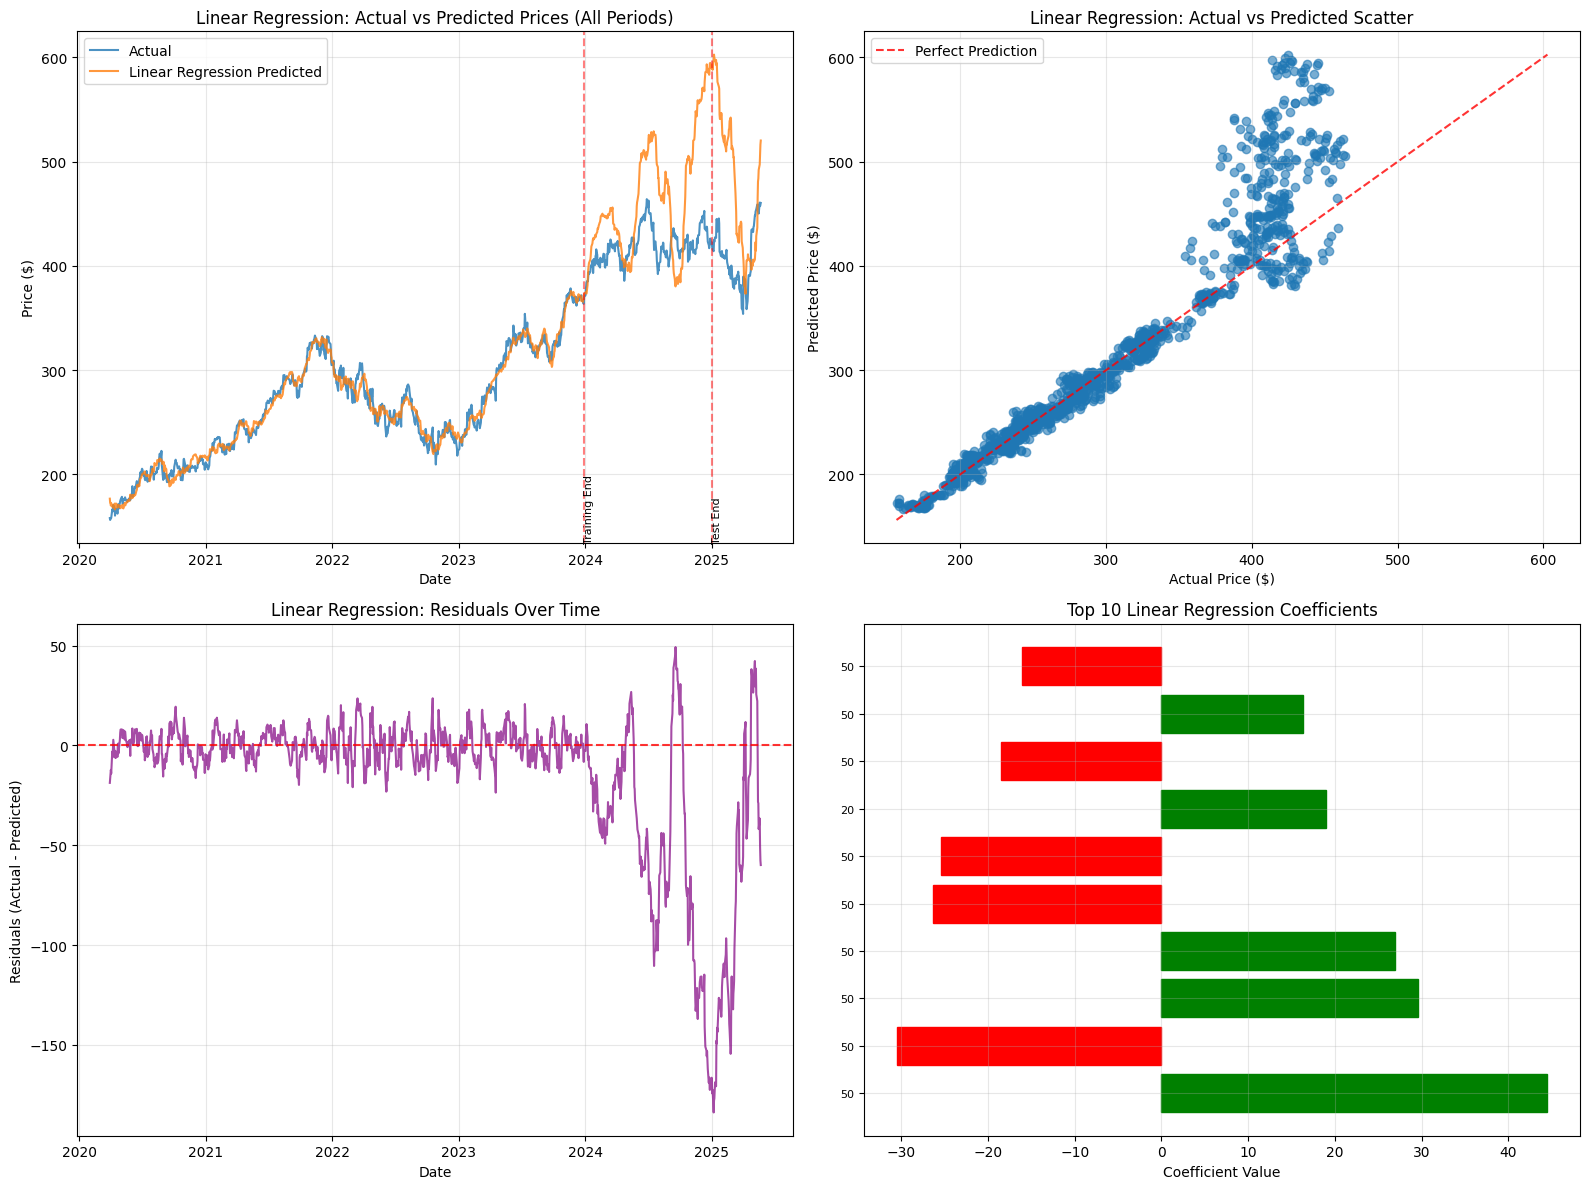


Selected Linear Regression Features (40):
 1. SPY_BB_Middle                            Coefficient:  10.0360
 2. VTI_BB_Middle                            Coefficient:  -9.5313
 3. MSFT_Close_sma_50                        Coefficient:   6.2549
 4. MSFT_High_sma_50                         Coefficient:  -6.2322
 5. AAPL_Close_sma_10                        Coefficient:  -2.5662
 6. AAPL_Low_sma_10                          Coefficient:   2.3930
 7. AAPL_Close_sma_20                        Coefficient:  18.9382
 8. AAPL_High_sma_20                         Coefficient: -10.3263
 9. AAPL_Low_sma_20                          Coefficient:  -8.6108
10. AMZN_Close_sma_20                        Coefficient:  -0.1872
11. GOOGL_High_sma_50                        Coefficient:   5.1535
12. GOOGL_Low_sma_50                         Coefficient:  -4.9798
13. CRM_Close_sma_50                         Coefficient:  -1.7950
14. CRM_High_sma_50                          Coefficient:   1.7929
15. NVDA_Close_sma_

In [19]:
# =============================================================================
# LINEAR REGRESSION VISUALIZATIONS
# =============================================================================

print("\n=== LINEAR REGRESSION VISUALIZATIONS ===")

# 1. LINEAR REGRESSION FIT CHART
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Combine all clean targets and predictions for plotting
all_actual_clean = pd.concat([y_train_clean, y_test_clean, y_strategy_clean]).sort_index()
all_predictions_lr = pd.concat([
    lr_predictions_rfe['training'], 
    lr_predictions_rfe['test'], 
    lr_predictions_rfe['strategy']
]).sort_index()

# Main time series plot
ax1 = axes[0, 0]
ax1.plot(all_actual_clean.index, all_actual_clean.values, label='Actual', alpha=0.8, linewidth=1.5)
ax1.plot(all_predictions_lr.index, all_predictions_lr.values, label='Linear Regression Predicted', alpha=0.8, linewidth=1.5)

# Add period separators
period_dates = {
    'Training End': y_train_clean.index[-1] if len(y_train_clean) > 0 else None,
    'Test End': y_test_clean.index[-1] if len(y_test_clean) > 0 else None
}

for label, date in period_dates.items():
    if date is not None:
        ax1.axvline(x=date, color='red', linestyle='--', alpha=0.5)
        ax1.text(date, ax1.get_ylim()[0], label, rotation=90, verticalalignment='bottom', fontsize=8)

ax1.set_title('Linear Regression: Actual vs Predicted Prices (All Periods)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Scatter plot: Actual vs Predicted
ax2 = axes[0, 1]
ax2.scatter(all_actual_clean.values, all_predictions_lr.values, alpha=0.6)
# Perfect prediction line
min_val = min(all_actual_clean.min(), all_predictions_lr.min())
max_val = max(all_actual_clean.max(), all_predictions_lr.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect Prediction')
ax2.set_xlabel('Actual Price ($)')
ax2.set_ylabel('Predicted Price ($)')
ax2.set_title('Linear Regression: Actual vs Predicted Scatter')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Residuals over time
ax3 = axes[1, 0]
residuals_lr = all_actual_clean.values - all_predictions_lr.values
ax3.plot(all_actual_clean.index, residuals_lr, alpha=0.7, color='purple')
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.8)
ax3.set_title('Linear Regression: Residuals Over Time')
ax3.set_xlabel('Date')
ax3.set_ylabel('Residuals (Actual - Predicted)')
ax3.grid(True, alpha=0.3)

# Feature coefficients
ax4 = axes[1, 1]
coef_df = pd.DataFrame({
    'Feature': selected_features_rfe,
    'Coefficient': lr_final_rfe.coef_
}).sort_values('Coefficient', key=abs, ascending=False).head(10)

bars = ax4.barh(range(len(coef_df)), coef_df['Coefficient'])
ax4.set_yticks(range(len(coef_df)))
ax4.set_yticklabels([f.split('_')[-1] for f in coef_df['Feature']], fontsize=8)
ax4.set_xlabel('Coefficient Value')
ax4.set_title('Top 10 Linear Regression Coefficients')
ax4.grid(True, alpha=0.3)

# Color bars by sign
for i, bar in enumerate(bars):
    if coef_df['Coefficient'].iloc[i] >= 0:
        bar.set_color('green')
    else:
        bar.set_color('red')

plt.tight_layout()
plt.show()

# Print Linear Regression feature details
print(f"\nSelected Linear Regression Features ({len(selected_features_rfe)}):")
for i, feature in enumerate(selected_features_rfe):
    coef = lr_final_rfe.coef_[i]
    print(f"{i+1:2d}. {feature:40s} Coefficient: {coef:8.4f}")

# Summary of Linear Regression Performance
print(f"\n=== LINEAR REGRESSION SUMMARY ===")
print("Performance across periods:")
for period, period_metrics in lr_metrics_rfe.items():
    print(f"{period.capitalize():10s}: R² = {period_metrics['r2']:.4f}, MSE = {period_metrics['mse']:.4f}")